In [449]:
# read each job post
# tokenize sentences
# remove non-ascii characters and punctuations
# tokenize words
# form bi-grams and tri-grams

import logging
import re
import os

# text pre-processing
import nltk
from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from string import punctuation, maketrans, translate

# stopwords
import stop_words

# gensim corpus and models
import gensim
from gensim import corpora, models, similarities
from gensim.models import Phrases

In [450]:
DATA_DIR = os.path.join("/home", "rt", "wrk", "jobs", "data")
MODEL_DIR = os.path.join("/home", "rt", "wrk", "jobs", "models")

In [126]:

class JobCorpus(object):
    def __init__(self, fname, stopwords=False, stemming=False):
        self.fname = fname
        self.remove_stopwords = stopwords
        self.stemming = stem

        # blackist words to be removed from text
        # combines stopwords from nltk, gensim and stop_words package
        self.en_stopwords = set(
            stop_words.get_stop_words('en') +
            nltk.corpus.stopwords.words("english") +
            list(gensim.parsing.preprocessing.STOPWORDS)
        )

        # keep -, +, # in words
        self.punctuation = re.sub("[-+#.]", " ", punctuation)

        # make translation dictionary converting punctuations to white spaces
        self.translate_dict = maketrans(punctuation, ' '*len(punctuation))

        # replace patterns
        self.invalid_char = re.compile(r'[0-9]|\\~|\`|\@|\$|\%|\^|\& \
                |\*|\(|\)|\_|\=|\[|\]|\\|\<|\<|\>|\?|\/|\;|\\.')
        self.url_pattern = re.compile(r'(' +
              # Scheme (HTTP, HTTPS, FTP and SFTP):
              r'(?:(https?|s?ftp):\/\/)?' +
              # www:
              r'(?:www\.)?' + 
              r'(' +
              # Host and domain (including ccSLD):
              r'(?:(?:[A-Z0-9][A-Z0-9-]{0,61}[A-Z0-9]\.)+)' +
              # TLD:
              r'([A-Z]{2,6})' +
              # IP Address:
              r'|(?:\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' +
              r')' +
              # Port:
              r'(?::(\d{1,5}))?' +
              # Query path:
              r'(?:(\/\S+)*)' +
              r')', re.IGNORECASE)

        # generator of documents; one element = list of words
        documents = (self.sentence_stream())

        # best bigrams and trigrams
        logging.warning("collecting ngrams")
        self.ngrams = self.best_ngrams(list(documents))
        logging.warning("completed collecting ngrams")

        logging.warning("building dictionary")
        self.dictionary = gensim.corpora.Dictionary(self.tokenize())
        #self.dictionary.compactify()
        self.dictionary.save(os.path.join(MODEL_DIR, "train.dict"))
        self.dictionary.save_as_text(os.path.join(MODEL_DIR, "train.dict.txt"))
        logging.warning(self.dictionary)
        logging.warning("completed building dictionary")
                
    def best_ngrams(self, sentences, threshold=10, min_count=100):
        """
        Extract most salient collocations (bigrams and trigrams) from a stream
        of words. Ignore collocations with frequency lower than `min_count`.

        threshold represents a threshold for forming the phrases (higher means
        fewer phrases). A phrase of words a and b is accepted if
        (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold,
        where N is the total vocabulary size.
        """
        
        bigrams = Phrases(list(sentences),
                          threshold=threshold,
                          min_count=min_count)
        trigrams = Phrases(bigrams[list(sentences)],
                           threshold=threshold,
                           min_count=min_count)
        fourgrams = Phrases(trigrams[list(sentences)],
                           threshold=threshold,
                           min_count=min_count)
        fivegrams = Phrases(fourgrams[list(sentences)],
                           threshold=threshold,
                           min_count=min_count)
        
        return trigrams

    def cleanse_text(self, text):
        clean_text = text

        # remove urls from text
        clean_text = self.url_pattern.sub('', clean_text)
        
        # remove punctuations and other characters
        clean_text = translate(
            self.invalid_char.sub(' ', clean_text),
            self.translate_dict)

        return clean_text

    def split_words(self, document):
        """
        Break text into sentences and each sentence into a list of single words
        Ignore any token that falls into the stopwords set.
        """
        # use sentence tokenizer sent_tokenize from nltk package
        sentences = sent_tokenize(document.lower().decode('unicode_escape').encode('ascii', 'ignore'))
        
        # create stemmer of class SnowballStemmer
        stemmer = SnowballStemmer("english")
        
        for sentence in sentences:
            words = [word
                   for word in gensim.utils.tokenize(
                    self.cleanse_text(sentence)
                   )]

            if self.remove_stopwords:
                words = [ 
                         word for word in words 
                         if word not in self.en_stopwords
                        ]
            
            if self.stemming:
                words = [stemmer.stem(t) for t in words]
            
            yield words

    def tokenize(self):
        """
        Break text (string) into a list of unicode tokens.
        The resulting tokens can be longer phrases (collocations) too,
        e.g. `new_york`, `real_estate` etc.
        """
        for document in open(self.fname):
            post = []
            for sentences in self.split_words(document):
                post.extend(self.ngrams[list(sentences)])
            yield post

    def sentence_stream(self):
        for document in open(self.fname):
            post = []
            for sentences in self.split_words(document):
                post.extend(list(sentences))
            yield post
            
    def __iter__(self):
        for sentence in self.tokenize():
            yield self.dictionary.doc2bow(sentence)


In [17]:
jobs_corpus = JobCorpus(os.path.join(DATA_DIR, "train.txt"))

In [18]:
corpora.MmCorpus.serialize(os.path.join(MODEL_DIR, "train_jobs.mm"), jobs_corpus)

In [19]:
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))
print corpus

MmCorpus(10000 documents, 44061 features, 1984177 non-zero entries)


---

In [47]:
MAX_LSI_TOPICS = 100

In [48]:
%%time
dictionary = corpora.Dictionary.load(os.path.join(MODEL_DIR, "train.dict"))
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))

tfidf = models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

# reduce the vector space by projecting  to 10 dimensions
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics = MAX_LSI_TOPICS)

CPU times: user 34.3 s, sys: 4.85 s, total: 39.1 s
Wall time: 40.4 s


In [50]:
# write coordinates to file
fcoords = open(os.path.join(MODEL_DIR, "train_jobs_lsi_coords.csv"), 'wb')
for vector in lsi[corpus]:
    if len(vector) != MAX_LSI_TOPICS:
        continue
    v = '\t'.join([ "{:6.6f}".format(x[1]) for x in vector ])
    fcoords.write(v + '\n')
fcoords.close()

---

In [283]:
# data processing
import numpy as np
import pandas as pd

# learning algorithms
from sklearn.cluster import KMeans, MiniBatchKMeans

# plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag()

In [52]:
MAX_K = 300

In [61]:
X = np.loadtxt(os.path.join(MODEL_DIR, "train_jobs_lsi_coords.csv"), delimiter="\t")
init = 1
ks = range(init, MAX_K + 1)

inertias = np.zeros(MAX_K+1-init)
diff = np.zeros(MAX_K+1-init)
diff2 = np.zeros(MAX_K+1-init)
diff3 = np.zeros(MAX_K+1-init)

In [62]:
for k in ks:
    #kmeans = KMeans(k).fit(X)
    kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, init_size=1000, batch_size=1000).fit(X)
    inertias[k - init - 1] = kmeans.inertia_
    # first difference    
    if k > 1:
        diff[k - init - 1] = inertias[k - init - 1] - inertias[k - init - 2]
    # second difference
    if k > 2:
        diff2[k - init - 1] = diff[k - init - 1] - diff[k - init - 2]
    # third difference
    if k > 3:
        diff3[k - init - 1] = diff2[k - init - 1] - diff2[k - init - 2]

elbow = np.argmin(diff3[3:]) + 3
print elbow

151


In [57]:
print len(inertias), len(ks)

301 301


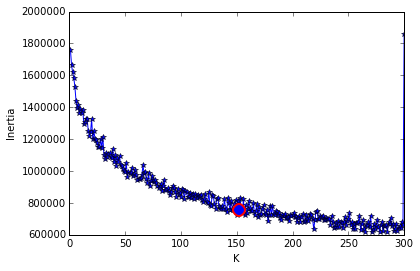

In [63]:
plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

---

In [64]:
%%time
dictionary = corpora.Dictionary.load(os.path.join(MODEL_DIR, "train.dict"))
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))

# Project to LDA space
NUM_TOPICS = 150
lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS, 
                             chunksize=2000, 
                             passes=20, 
                             alpha='auto',
                             eval_every=10,
                             minimum_probability=0.01
                            )

CPU times: user 45min 9s, sys: 1min 8s, total: 46min 17s
Wall time: 46min 29s


In [65]:
lda.save(os.path.join(MODEL_DIR, "train_model.lda"))

In [381]:
dictionary = corpora.Dictionary.load(os.path.join(MODEL_DIR, "train.dict"))
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(MODEL_DIR, "train_model.lda"))

In [382]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

/usr/local/lib/python2.7/dist-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:102: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.00516356082502 and the largest is 2.43232738614.
  RuntimeWarning


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
20     6.940002        1       1 -0.235701  0.133466
74     3.975794        1       2 -0.140762  0.158604
79     3.296870        1       3 -0.215013 -0.011162
118    3.086386        1       4 -0.221878 -0.045682
146    2.902655        1       5 -0.214077 -0.131403
49     2.617044        1       6 -0.166079 -0.024823
114    2.588486        1       7 -0.225615  0.152555
60     2.281884        1       8 -0.146752 -0.038812
135    2.259786        1       9 -0.166109  0.228074
70     2.006800        1      10 -0.168714 -0.001637
69     1.796352        1      11 -0.196257  0.113511
54     1.783289        1      12 -0.129837  0.187924
129    1.781065        1      13 -0.122678 -0.056346
102    1.728028        1      14 -0.180288  0.208806
148    1.640995        1      15 -0.148133 -0.136451
117    1.585782        1      16 -0.172912 -0.079267
138    1.560796        1      17 -0.153768 -0.113739
40     1.511685        1      18 -0.058578  0.001693
27     1.461527        1      19 -0.168485  0.007516
115    1.429871        1      20 -0.148430 -0.020626
8      1.414878        1      21 -0.198340 -0.031358
106    1.413914        1      22 -0.163670 -0.133183
71     1.384965        1      23 -0.133990 -0.172406
15     1.360141        1      24 -0.137582  0.069828
6      1.325443        1      25 -0.081771 -0.010047
124    1.293278        1      26 -0.161644  0.097589
126    1.284585        1      27 -0.138639  0.065594
137    1.136240        1      28 -0.105957  0.051263
12     1.090035        1      29 -0.146099 -0.130370
149    1.000669        1      30 -0.131484 -0.095749
...         ...      ...     ...       ...       ...
72     0.135460        1     121  0.056083 -0.045059
3      0.135277        1     122  0.164426 -0.012665
144    0.131447        1     123  0.107740  0.055003
105    0.123712        1     124  0.177809 -0.005765
67     0.121455        1     125  0.175767  0.005161
93     0.119197        1     126  0.168669  0.028947
97     0.117780        1     127  0.072477 -0.043955
53     0.116322        1     128  0.147486  0.014006
18     0.107036        1     129  0.184195 -0.009352
76     0.105646        1     130  0.129026 -0.036133
98     0.101107        1     131  0.150860  0.006941
29     0.100007        1     132  0.132751  0.026366
13     0.090034        1     133  0.199732  0.001890
46     0.088907        1     134  0.094556  0.062629
109    0.088683        1     135  0.198538  0.013238
48     0.086377        1     136  0.224033  0.002297
14     0.085157        1     137  0.184640  0.013784
37     0.083494        1     138  0.146468  0.015975
116    0.083276        1     139  0.215013  0.003266
141    0.081784        1     140  0.197981 -0.003438
66     0.079277        1     141  0.202564  0.002000
80     0.065335        1     142  0.205967  0.012790
34     0.061184        1     143  0.223180  0.000285
65     0.056962        1     144  0.232933 -0.003551
122    0.055665        1     145  0.231607 -0.004728
19     0.054697        1     146  0.233558 -0.003647
0      0.054477        1     147  0.235957 -0.008699
25     0.048163        1     148  0.198172 -0.012842
81     0.038479        1     149  0.246649 -0.000309
142    0.036847        1     150  0.249017 -0.004889

[150 rows x 5 columns], topic_info=       Category          Freq          Term         Total  loglift  logprob
term                                                                       
11437   Default  18133.000000          data  18133.000000  30.0000  30.0000
10317   Default  16556.000000       ability  16556.000000  29.0000  29.0000
1384    Default  33727.000000    experience  33727.000000  28.0000  28.0000
14665   Default   7348.000000         sales   7348.000000  27.0000  27.0000
1529    Default   4711.000000      research   4711.000000  26.0000  26.0000
12658   Default   7405.000000      customer   7405.000000  25.

In [337]:
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(MODEL_DIR, "train_model.lda"))

In [346]:
lda.show_topics(num_topics=10)

(25,
 u'0.037*minorities_females + 0.016*eoe + 0.013*link + 0.011*forecasted + 0.010*srm + 0.010*disability + 0.009*manager + 0.009*bimbo + 0.009*working + 0.008*shall')

In [357]:
for topicIndex, freqsTerms in lda.show_topics(num_topics=10):
    freqs = [float(x.split("*")[0]) for x in freqsTerms.split(" + ")]
    terms = [x.split("*")[1] for x in freqsTerms.split(" + ")]

    for term, value in zip(terms, freqs):
        print topicIndex, term, value

minorities_females 0.037
eoe 0.016
link 0.013
forecasted 0.011
srm 0.01
disability 0.01
manager 0.009
bimbo 0.009
working 0.009
shall 0.008
wastewater 0.027
soa 0.026
version 0.022
mae 0.018
forensic 0.017
employment 0.017
fannie 0.017
treatment 0.016
knowledge 0.016
va 0.014
real_estate 0.15
valuation 0.07
micro 0.044
dream 0.027
principals 0.025
unions 0.022
alexandria 0.018
macro 0.016
maintainability 0.015
compiled 0.015
treatment 0.031
patient 0.021
dialysis 0.017
patients 0.015
appropriate 0.014
lab 0.012
including 0.012
customer_service 0.011
home 0.01
according 0.01
commissions 0.044
club 0.037
gaming 0.037
nh 0.035
fi 0.034
lake 0.031
resort 0.022
players 0.02
concierge 0.019
transport 0.019
data 0.053
analysis 0.044
business 0.029
experience 0.022
analyst 0.018
reporting 0.017
reports 0.017
support 0.015
management 0.013
analyze 0.012
experience 0.034
required 0.021
work 0.019
position 0.019
time 0.018
skills 0.017
job 0.014
able 0.01
data_entry 0.01
data 0.01
business 0.014


In [76]:
ftopics = open(os.path.join(MODEL_DIR, "train_jobs_topics.txt"), 'wb')
for t in lda.print_topics(NUM_TOPICS, 50):
    ftopics.write(str(t[0]) + ':' + t[1] + '\n')
ftopics.close()

In [67]:
fjobtopics = open(os.path.join(MODEL_DIR, "train_jobs_topics.csv"), 'wb')
for doc_id in range(len(corpus)):
    docbow = corpus[doc_id]
    doc_topics = lda.get_document_topics(docbow)
    for topic_id, topic_prob in doc_topics:
        fjobtopics.write("%d\t%d\t%.3f\n" % (doc_id, topic_id, topic_prob))
fjobtopics.close()

In [323]:
topic_df = pd.read_csv(os.path.join(MODEL_DIR, "train_jobs_topics.csv"), sep="\t", 
                   names=["doc_id", "topic_id", "topic_prob"], 
                   skiprows=0)

In [73]:
topic_idx = topic_df.groupby(['doc_id'])['topic_prob'].transform(max) == topic_df['topic_prob']
top_topics = topic_df[topic_idx]
top_topics.groupby(['topic_id'])['topic_id'].agg(['count']).sort_values(by = ['count'], ascending=False)

count
topic_id       
20         1033
49          543
146         513
135         503
74          368
114         365
79          307
138         293
70          285
54          276
8           243
124         237
102         221
118         209
137         178
61          171
126         169
69          157
71          149
117         141
129         140
115         128
106         128
128         114
1           105
90          102
84          100
58          100
6            98
60           97
...         ...
53            7
24            7
104           7
82            7
25            7
45            7
127           6
86            6
28            6
48            5
133           5
111           5
93            4
13            4
16            4
98            4
46            3
80            3
66            3
109           3
18            3
119           3
29            3
47            2
134           2
105           2
14            2
3             2
116           2
19            1

[142 rows x 1 columns]

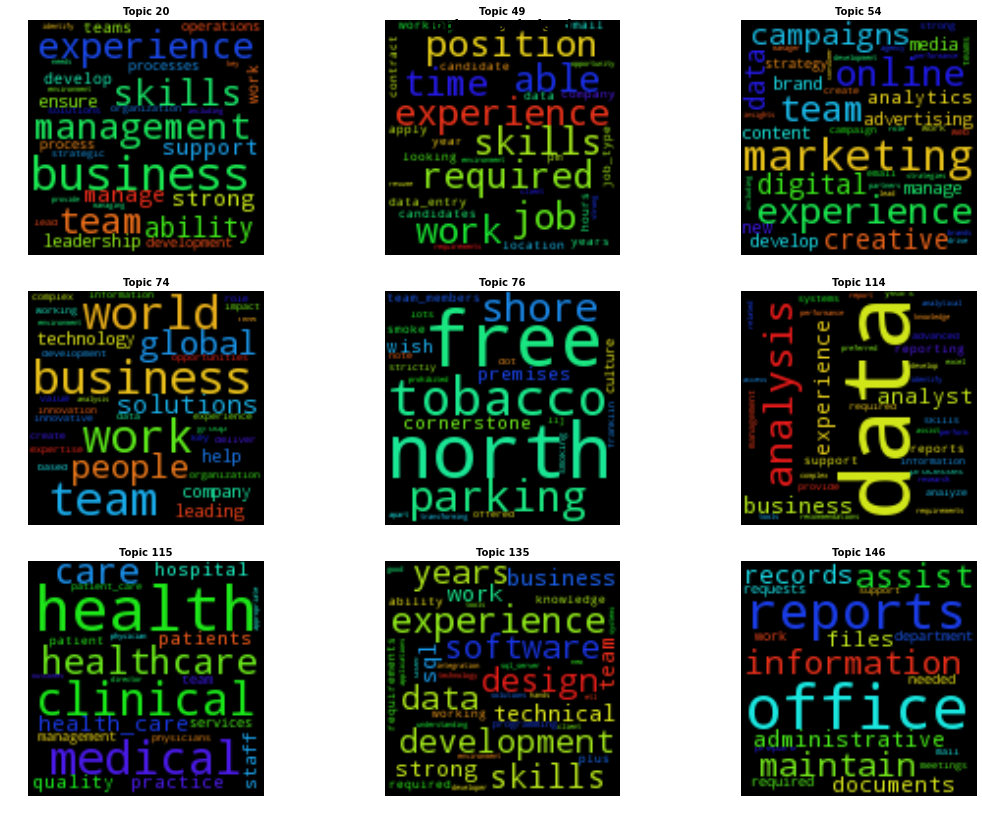

In [284]:
final_topics = open(os.path.join(MODEL_DIR, "train_jobs_topics.txt"), 'rb')
v = 0
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(left = 0.1, bottom=0.1, right=0.2, top=0.2)
wordcloud_topics = [20, 49, 146, 135, 74, 114, 54, 115, 76]
number_of_subplots=len(wordcloud_topics)

for line in final_topics:
    line = line.strip('\n')
    curr_topic = line.split(':')[0]
    topic_scores = ''.join(line.split(':')[1:])

    if int(curr_topic) in wordcloud_topics:
        scores = [float(x.split("*")[0]) for x in topic_scores.split(" + ")]
        words = [x.split("*")[1] for x in topic_scores.split(" + ")]

        freqs = []
        for word, score in zip(words, scores):
            freqs.append((word, score))

        elements = WordCloud(width=120, height=120).fit_words(freqs)

        v += 1
        ax1 = fig.add_subplot(int(number_of_subplots/3)+1, 3, v)
        ax1.set_title("Topic {}".format(curr_topic), fontsize=10, fontweight='bold')
        ax1.imshow(elements)
        ax1.axis("off")
    else:
        continue

fig.suptitle("Topics Word Cloud", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
final_topics.close()

In [85]:
import matplotlib
matplotlib.matplotlib_fname()

u'/usr/local/lib/python2.7/dist-packages/matplotlib/mpl-data/matplotlibrc'

In [86]:
import matplotlib.rcsetup as rcsetup
print(rcsetup.all_backends)

[u'GTK', u'GTKAgg', u'GTKCairo', u'MacOSX', u'Qt4Agg', u'Qt5Agg', u'TkAgg', u'WX', u'WXAgg', u'CocoaAgg', u'GTK3Cairo', u'GTK3Agg', u'WebAgg', u'nbAgg', u'agg', u'cairo', u'emf', u'gdk', u'pdf', u'pgf', u'ps', u'svg', u'template']


In [372]:
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(MODEL_DIR, "train_model.lda"))

In [384]:
fjobtopics = open(os.path.join(MODEL_DIR, "train_jobs_topics.csv"), 'wb')
for doc_id in range(len(corpus)):
    docbow = corpus[doc_id]
    doc_topics = lda.get_document_topics(docbow)
    for topic_id, topic_prob in doc_topics:
        fjobtopics.write("%d\t%d\t%.3f\n" % (doc_id, topic_id, topic_prob))
fjobtopics.close()

In [385]:
topic_df = pd.read_csv(os.path.join(MODEL_DIR, "train_jobs_topics.csv"), sep="\t", 
                   names=["doc_id", "topic_id", "topic_prob"], 
                   skiprows=0)

In [386]:
len(topic_df)

133537

In [448]:
topic_idx = topic_df.groupby(['doc_id'])['topic_prob'].transform(max) == topic_df['topic_prob']
doc_by_top_topic = topic_df[topic_idx]

doc_by_topic = { v[1]:v[2] for v in doc_by_top_topic.itertuples()}
#print len(doc_by_topic.keys())

#print doc_by_top_topic.head()
topic_with_docs = {}
for t in doc_by_top_topic.itertuples():
    k = t[2]
    v = t[1]
    if topic_with_docs.has_key(k):
        topic_with_docs[k].append(v)
    else:
        topic_with_docs[k] = []
        topic_with_docs[k].append(v)

total = 0
for topic, docs in topic_with_docs.iteritems():
    print topic, len(docs)
print total

1 105
2 13
3 2
4 17
5 18
6 98
7 9
8 244
9 8
10 79
11 20
12 71
13 4
14 2
15 43
16 4
17 22
18 3
19 1
20 1040
21 72
22 14
23 79
24 7
25 6
26 15
27 53
28 6
29 3
30 23
31 43
32 81
33 43
35 27
36 62
37 8
38 56
39 8
40 63
41 11
42 75
43 38
44 46
45 7
46 3
47 2
48 5
49 542
50 37
51 10
52 14
53 7
54 276
55 50
56 13
57 35
58 100
59 36
60 98
61 171
62 12
63 12
64 9
66 3
68 20
69 157
70 284
71 149
72 17
73 7
74 367
75 27
76 9
77 81
78 20
79 306
80 3
82 7
83 17
84 100
85 29
86 6
87 21
88 54
89 17
90 102
91 27
92 23
93 4
94 20
95 10
96 9
97 9
98 4
99 15
100 11
101 15
102 221
103 25
104 7
105 2
106 130
107 33
108 17
109 3
110 30
111 5
112 40
113 23
114 362
115 127
116 2
117 139
118 208
119 3
120 12
121 31
123 29
124 237
125 35
126 170
127 6
128 113
129 140
130 27
131 95
132 23
133 5
134 2
135 498
136 9
137 178
138 293
139 12
140 17
143 19
144 13
145 13
146 514
147 15
148 69
149 62
0


In [428]:
fdoctopics = open(os.path.join(MODEL_DIR, "train_topic_by_doc.csv"), 'wb')
for k, v in doc_by_topic.iteritems():
    fdoctopics.write(str(k) + ',' + str(v) + '\n')
fdoctopics.close()

In [437]:
ftopicdocs = open(os.path.join(MODEL_DIR, "train_doc_by_topic.csv"), 'wb')
for k, v in topic_with_docs.iteritems():
    ftopicdocs.write(str(k) + ',' + ','.join([ str(x) for x in v]) + '\n')
ftopicdocs.close()

In [422]:
ftopicterms = open(os.path.join(MODEL_DIR, "train_jobs_topic_terms.csv"), 'wb')
for topicIndex, freqsTerms in lda.show_topics(num_topics=150, num_words=50):
    freqs = [float(x.split("*")[0]) for x in freqsTerms.split(" + ")]
    terms = [x.split("*")[1] for x in freqsTerms.split(" + ")]
    
    scores = [ k.encode('utf-8') + ':' + str(v) for k, v in sorted(zip(terms, freqs), key= lambda tup: tup[1], reverse = True)[:20] ]
    ftopicterms.write(str(topicIndex) + ',' + ','.join(scores) + '\n')
ftopicterms.close()

In [389]:
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

In [388]:
class LabeledLineSentence(object):
    def __init__(self, fname, docbytopic):
        self.fname = fname
        self.docbytopic = docbytopic
        
    def __iter__(self):
        for uid, line in enumerate(open(filename)):
            yield LabeledSentence(words=line.split(), labels=['SENT_%s' % docbytopic[uid]])

In [ ]:
class LabeledLineSentence(object):
    def __init__(self, fname, docbytopic):
        self.fname = fname
        self.docbytopic = docbytopic
    
    def __iter__(self):
        for uid, line in enumerate(open(filename)):
            yield LabeledSentence(words=utils.to_unicode(line).split(), labels=['SENT_%s' % self.docbytopic[uid]])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffle(self.sentences)
        return self.sentences

In [ ]:
model = Doc2Vec(alpha=0.025, min_alpha=0.025)  # use fixed learning rate
model.build_vocab(sentences)
for epoch in range(10):
    model.train(sentences)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

---

In [70]:
!tail -3 ~/wrk/jobs/data/export_jobs_w_title.txt | awk -F'|' '{print $5}' > ~/wrk/jobs/data/test.txt
!tail -3 ~/wrk/jobs/data/export_jobs_w_title.txt | awk -F'|' '{print $1"|"$2"|"$3"|"$4}' > ~/wrk/jobs/data/test_labels.txt
!cat ~/wrk/jobs/data/test.txt
!cat ~/wrk/jobs/data/test_labels.txt

J.P. Morgan's Corporate & Investment Bank is a global leader across banking, markets and investor services. The world's most important corporations, governments and institutions entrust us with their business in more than 100 countries. With $18 trillion of assets under custody and $393 billion in deposits, the Corporate & Investment Bank provides strategic advice, raises capital, manages risk and extends liquidity in markets around the world. Market Risk Technology team is responsible for the technology platform and integration with JPM Morganâs risk systems to provide JP Morganâs risk managers with capability to assess impact of various market scenarios at a firm wide level. The team has a large book of work comprising of many strategic and tactical projects to enhance the system capabilities and continue with integration efforts with the firmâs risk systems along with the reduction of offline manual processes.   As a Senior Lead Architect, you will play important role in leadi

In [23]:
print os.path.join(DATA_DIR, "test.txt")

/home/rt/wrk/jobs/data/test.txt


In [316]:
for d in sentence_stream(open('/home/rt/wrk/jobs/data/test.txt')):
    print d

TypeError: coercing to Unicode: need string or buffer, file found

In [43]:
# compile sample documents into a list
dictionary = corpora.Dictionary.load(os.path.join(MODEL_DIR, "train.dict"))
dictionary.add_documents(sentence_stream(os.path.join(DATA_DIR, "test.txt")))
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))

In [75]:
#test_dict = corpora.Dictionary(sentence_stream(os.path.join(DATA_DIR, "test.txt")))
test_bow = []
for sentence in sentence_stream(os.path.join(DATA_DIR, "test.txt")):
    test_bow.append(dictionary.doc2bow(sentence))

In [72]:
for sentence in sentence_stream(os.path.join(DATA_DIR, "test.txt")):
    print len(sentence)

417
483
342


In [76]:
test_topics = lda[test_bow]

In [99]:
for t in test_topics:
    [ x for x,y in sorted(t, key=lambda tup: tup[1], reverse = True)[:5] ]

[20, 69, 74, 102, 135]
[115, 57, 146, 61, 74]
[74, 54, 20, 101, 94]


In [115]:
final_topics = open(os.path.join(MODEL_DIR, "train_jobs_topics.txt"), 'rb')
topic_terms = {}

for line in final_topics:
    line = line.strip('\n')
    curr_topic = line.split(':')[0]
    topic_scores = ''.join(line.split(':')[1:])

    scores = [float(x.split("*")[0]) for x in topic_scores.split(" + ")]
    words = [x.split("*")[1] for x in topic_scores.split(" + ")]

    freqs = []
    for word, score in zip(words, scores):
        freqs.append((word, score))
    
    topic_terms[int(curr_topic)] = sorted(freqs, key=lambda tup: tup[1], reverse = True)[:50]

In [120]:
for t in test_topics:
    topn_topics = [ x for x,y in sorted(t, key=lambda tup: tup[1], reverse = True)[:5] ]
    terms = []
    for topic in topn_topics:
        print topic, topic_terms[topic]

20 [('business', 0.02), ('management', 0.02), ('experience', 0.014), ('team', 0.013), ('skills', 0.012)]
69 [('project', 0.088), ('requirements', 0.028), ('projects', 0.025), ('business', 0.019), ('work', 0.015)]
74 [('business', 0.014), ('work', 0.012), ('team', 0.009), ('world', 0.007), ('people', 0.007)]
102 [('experience', 0.036), ('systems', 0.032), ('database', 0.022), ('application', 0.022), ('management', 0.019)]
135 [('experience', 0.057), ('development', 0.02), ('data', 0.018), ('design', 0.017), ('skills', 0.016)]
115 [('health', 0.046), ('clinical', 0.038), ('medical', 0.036), ('healthcare', 0.036), ('care', 0.026)]
57 [('treatment', 0.031), ('patient', 0.021), ('dialysis', 0.017), ('patients', 0.015), ('appropriate', 0.014)]
146 [('office', 0.018), ('reports', 0.017), ('information', 0.015), ('maintain', 0.014), ('assist', 0.012)]
61 [('patient', 0.062), ('patients', 0.04), ('information', 0.024), ('medical', 0.017), ('required', 0.013)]
74 [('business', 0.014), ('work', 0

In [312]:
test_df = pd.read_csv(os.path.join(DATA_DIR, "test_labels.txt"), sep="|", names = ['id', 'title','company', 'url'], skiprows=0)
test_df[['title', 'company']]

title  \
0                              RFRM-2 Lead Architect   
1                                         Ward Clerk   
2  Associate Director/Director – Commercial Analy...   

                             company  
0  JPMorgan Chase - Asset Management  
1             Fresenius Medical Care  
2                             Axtria

---

In [128]:
dictionary = corpora.Dictionary.load(os.path.join(MODEL_DIR, "train.dict"))
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))

In [130]:
jobs_corpus = JobCorpus(os.path.join(DATA_DIR, "train.txt"))

In [131]:
print jobs_corpus

In [136]:
class MySentences(object):
    def __init__(self, fname):
        self.fname = fname
        
    def __iter__(self):
        for line in open(self.fname):
            yield line.split()

sentences = MySentences(os.path.join(DATA_DIR, "train.txt"))

In [143]:
class Word2VecSentences(object):
    def __init__(self, fname):
        self.fname = fname

        # blackist words to be removed from text
        # combines stopwords from nltk, gensim and stop_words package
        self.en_stopwords = set(
            stop_words.get_stop_words('en') +
            nltk.corpus.stopwords.words("english") +
            list(gensim.parsing.preprocessing.STOPWORDS)
        )

        # keep -, +, # in words
        self.punctuation = re.sub("[-+#.]", " ", punctuation)

        # make translation dictionary converting punctuations to white spaces
        self.translate_dict = maketrans(punctuation, ' '*len(punctuation))

        # replace patterns
        self.invalid_char = re.compile(r'[0-9]|\\~|\`|\@|\$|\%|\^|\& \
                |\*|\(|\)|\_|\=|\[|\]|\\|\<|\<|\>|\?|\/|\;|\\.')
        self.url_pattern = re.compile(r'(' +
              # Scheme (HTTP, HTTPS, FTP and SFTP):
              r'(?:(https?|s?ftp):\/\/)?' +
              # www:
              r'(?:www\.)?' + 
              r'(' +
              # Host and domain (including ccSLD):
              r'(?:(?:[A-Z0-9][A-Z0-9-]{0,61}[A-Z0-9]\.)+)' +
              # TLD:
              r'([A-Z]{2,6})' +
              # IP Address:
              r'|(?:\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' +
              r')' +
              # Port:
              r'(?::(\d{1,5}))?' +
              # Query path:
              r'(?:(\/\S+)*)' +
              r')', re.IGNORECASE)

    def cleanse_text(self, text):
        clean_text = text

        # remove urls from text
        clean_text = self.url_pattern.sub('', clean_text)
        
        # remove punctuations and other characters
        clean_text = translate(
            self.invalid_char.sub(' ', clean_text),
            self.translate_dict)

        return clean_text

    def split_words(self, document):
        """
        Break text into sentences and each sentence into a list of single words
        Ignore any token that falls into the stopwords set.
        """
        # use sentence tokenizer sent_tokenize from nltk package
        sentences = sent_tokenize(document.lower().decode('unicode_escape').encode('ascii', 'ignore'))
        
        for sentence in sentences:
            words = [word
                   for word in gensim.utils.tokenize(
                    self.cleanse_text(sentence)
                   )
                   if word not in self.en_stopwords]
            yield words

    def tokenize(self):
        """
        Break text (string) into a list of unicode tokens.
        The resulting tokens can be longer phrases (collocations) too,
        e.g. `new_york`, `real_estate` etc.
        """
        for document in open(self.fname):
            post = []
            for sentences in self.split_words(document):
                post.extend(list(sentences))
            yield post
            
    def __iter__(self):
        for sentence in self.tokenize():
            yield sentence

In [145]:
sentences = Word2VecSentences(os.path.join(DATA_DIR, "train.txt"))

In [146]:
word2vec = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5)

In [165]:
%%time
bigram_transformer = gensim.models.Phrases(sentences)
trigram_transformer = gensim.models.Phrases(bigram_transformer[sentences])
fourgram_transformer = gensim.models.Phrases(trigram_transformer[sentences])

CPU times: user 3min 19s, sys: 16.3 s, total: 3min 35s
Wall time: 3min 41s


In [166]:
%%time
word2vec = gensim.models.Word2Vec(fourgram_transformer[sentences], size=100, window=5, min_count=5)
word2vec.save(os.path.join(MODEL_DIR, "train_model.w2v"))

CPU times: user 2min 41s, sys: 13.4 s, total: 2min 54s
Wall time: 2min 57s


In [167]:
word2vec.most_similar(['machine_learning'])

[(u'algorithms', 0.8583469390869141),
 (u'predictive_modeling', 0.8387719988822937),
 (u'data_mining', 0.8214297294616699),
 (u'predictive_analytics', 0.7932194471359253),
 (u'nlp', 0.7907448410987854),
 (u'data_visualization', 0.7896145582199097),
 (u'statistical_modeling', 0.78826504945755),
 (u'data_modeling', 0.7874375581741333),
 (u'visualization', 0.7810636162757874),
 (u'modeling', 0.7794164419174194)]

In [322]:
word2vec.most_similar(['java'], topn=20)

[(u'javascript', 0.881230354309082),
 (u'hadoop', 0.8753098249435425),
 (u'unix_shell', 0.8747060894966125),
 (u'mongodb', 0.8734343647956848),
 (u'java_script', 0.8704915046691895),
 (u'cassandra', 0.8704385161399841),
 (u'web_services', 0.8689643144607544),
 (u'maven', 0.8659000992774963),
 (u'mysql', 0.8604804873466492),
 (u'web_development', 0.8602568507194519),
 (u'jdbc', 0.8577989935874939),
 (u'linux', 0.8567675948143005),
 (u'servlets', 0.8562617897987366),
 (u'python', 0.8561924695968628),
 (u'hands_experience', 0.8531144857406616),
 (u'scripting', 0.8522473573684692),
 (u'mvc', 0.8519222736358643),
 (u'xml', 0.8498892784118652),
 (u'net_framework', 0.849009096622467),
 (u'visual_studio', 0.8482654094696045)]

In [317]:
test_posts = [] 
for sentence in sentence_stream(os.path.join(DATA_DIR, "test.txt")):
    test_posts.append(sentence)

In [301]:
print len(word2vec.vocab.keys())

36506


In [318]:
i = 0
for test_post in test_posts:
    test_valid = [ word for word in test_post if word in word2vec.vocab.keys() ]
    i += 1
    print len(test_valid), len(test_post)
    for key in word2vec.most_similar(test_valid, topn=20):
        print key

412 417
(u'operating_model', 0.8180918097496033)
(u'close_collaboration', 0.8053417205810547)
(u'roadmap', 0.7970242500305176)
(u'define_implement', 0.7872893810272217)
(u'architecture_design', 0.786798894405365)
(u'product_managers', 0.7851475477218628)
(u'infrastructure_components', 0.7840683460235596)
(u'requirements_definition', 0.7814387083053589)
(u'proposing', 0.7814348340034485)
(u'customer_segmentation', 0.7809527516365051)
(u'architects', 0.778986930847168)
(u'roadmaps', 0.7777293920516968)
(u'researches_recommends', 0.7760335206985474)
(u'product_owners', 0.775299072265625)
(u'deliver_actionable', 0.7718074917793274)
(u'solution_architects', 0.7692503929138184)
(u'dev', 0.768485426902771)
(u'development_deployment', 0.7683247327804565)
(u'deep_understanding', 0.7647520303726196)
(u'implementations', 0.7647209763526917)
465 483
(u'continuity_care', 0.7628012895584106)
(u'needs_met', 0.7425606846809387)
(u'tands', 0.7423021197319031)
(u'reviews_performed', 0.740746796131134)
(

To quickly find clusters of similar features, used Mini-Batch Kmeans to cluster the word vectors. Goal is to identify similar skills for a given post.

In [201]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering

In [9]:
word2vec = gensim.models.Word2Vec.load(os.path.join(MODEL_DIR, "train_model.w2v"))

In [213]:
#the vector dictionary of the model
word2vec_dict={}
for i in word2vec.vocab.keys():
    try:
        word2vec_dict[i] = word2vec[i]
    except:    
        pass

In [227]:
#This is also interesting to try with Ward Hierarchical Clustering
clusters = MiniBatchKMeans(n_clusters=300, max_iter=10, batch_size=200, n_init=1, init_size=2000)
X = np.array([i.T for i in word2vec_dict.itervalues()])
y = [i for i in word2vec_dict.iterkeys()]

print X.shape

clusters.fit(X)
from collections import defaultdict
cluster_dict=defaultdict(list)
for word,label in zip(y,clusters.labels_):
    cluster_dict[label].append(word)

(36506, 100)


In [235]:
for i in range(len(cluster_dict)):
    if 'spark' in cluster_dict[i]:
        cluster_dict[i].sort()
        print cluster_dict[i]

[u'adobe', u'agile', u'agile_development', u'aix', u'algorithms', u'android', u'apache', u'api', u'apis', u'apple', u'applications', u'apps', u'arcgis', u'architecture', u'avaya', u'aws', u'bash', u'business_objects', u'cad', u'cassandra', u'citrix', u'client_server', u'cloud_computing', u'clustering', u'cognos', u'command_line', u'concepts', u'continuous_integration', u'crm', u'crystal_reports', u'css', u'data_manipulation', u'data_mining', u'data_modeling', u'data_models', u'data_sets', u'data_structures', u'data_visualization', u'data_warehouses', u'data_warehousing', u'database', u'database_administration', u'database_design', u'databases', u'dba', u'debugging', u'demonstrated_experience', u'deploying', u'depth_knowledge', u'design_patterns', u'designing_developing', u'distributed', u'distributed_systems', u'eclipse', u'ee', u'environments', u'etl', u'experience_configuring', u'expert_knowledge', u'expert_level', u'extensive_experience', u'familiar', u'familiarity', u'forensics', u

---

In [149]:
from gensim.models.phrases import Phrases
import spacy.parts_of_speech as pos
from spacy.en import English
import funcy as fp

DEFAULT_POS = set([pos.NOUN, pos.VERB, pos.ADV, pos.ADJ])
DEFAULT_STOPWORDS = en_stopwords | set(['pm','am', "'re", "'ve", "n't"])

nlp = English()

In [145]:
def pos_name(pos_id):
    if pos_id == pos.NOUN: return 'NOUN'
    if pos_id == pos.VERB: return 'VERB'
    if pos_id == pos.ADV: return 'ADV'
    if pos_id == pos.ADJ: return 'ADJ'
    return 'OTHER'

In [146]:
 def chunk(tokens, allowed_pos=DEFAULT_POS):
    split = []
    for token in tokens:
        orth, lemma, pos, tag = token
        if pos in allowed_pos:
            split.append(lemma +  '/' + pos_name(pos))
        else:
            # break detected!
            if len(split) > 1:
                yield split
            if len(split) > 0:
                split = []
    yield split

In [147]:
def chunk_doc(tokens):
    yield list(chunk(tokens))

In [150]:
def tokenize(s):
    tokens = nlp(unicode(s))
    r = [[t.orth_.lower(), t.lemma_.lower(), t.pos, t.tag] for t in tokens if t.orth_.strip()]
    return r

In [157]:
%%time
def stream_text(fname):
    for sentence in sentence_stream(fname):
        #yield fp.cat(fp.cat([d for d in chunk_doc(tokenize(' '.join(sentence)))]))
        yield fp.cat(fp.cat(chunk_doc(tokenize(' '.join(sentence)))))

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.06 µs


In [ ]:
i = 0
for t in stream_text(os.path.join(DATA_DIR, "test.txt")):
    i += 1
    print "[sentence] " + str(i) + " [chunks] " + str(len(t))
    print t

In [165]:
%%time
# train chunker now
bigram = Phrases(stream_text(os.path.join(DATA_DIR, "train.txt")))
trigram = Phrases(bigram[stream_text(os.path.join(DATA_DIR, "train.txt"))])

CPU times: user 10min 4s, sys: 11.7 s, total: 10min 15s
Wall time: 10min 19s


In [166]:
def extract_chunks(doc, min_len=3):
    yield [w for w in trigram[bigram[doc]] if len(w) >= min_len and w not in DEFAULT_STOPWORDS]

In [167]:
def processed_docs(fname):
    for chunked in stream_text(fname):
        yield fp.cat(extract_chunks(chunked))

In [191]:
dictionary = corpora.Dictionary(processed_docs(os.path.join(DATA_DIR, "train.txt")))
dictionary.save(os.path.join(MODEL_DIR, 'annotated_unfiltered.dict'))

In [198]:
print dictionary

Dictionary(79645 unique tokens: [u'withdifferent/NOUN', u'requiresfrequent/VERB', u'wood/VERB', u'repeat/NOUN_business/NOUN', u'oos/ADJ']...)


In [181]:
import re
for v in dictionary.values():
    print re.sub(r'\/([A-Z]*)', '', v)

In [259]:
unfiltered_dictionary = corpora.Dictionary.load(os.path.join(MODEL_DIR, 'annotated_unfiltered.dict'))

In [260]:
pos_re = re.compile(r'/(NOUN|ADJ|VERB|ADV)')
min_len = 3

bad_ids = []
for t in unfiltered_dictionary.token2id.keys():
    cleaned = pos_re.sub('', t) 
    if len(cleaned) < min_len or cleaned in DEFAULT_STOPWORDS or re.search(r'[;><"&=]', cleaned) or re.search(r'#.+#', cleaned):
        bad_ids.append(unfiltered_dictionary.token2id[t])
        
unfiltered_dictionary.filter_tokens(bad_ids)
unfiltered_dictionary.compactify()

In [212]:
from copy import deepcopy

def filter_dict(no_below=5, no_above=0.5, keep_n=None, bad_tokens=None, good_tokens=None, orig_dict=unfiltered_dictionary):
    print orig_dict
    dictionary = deepcopy(orig_dict)
    #def tokens2ids(words):
    #    if words: return [dictionary.token2id[w] for w in words]
    #if good_tokens or bad_tokens:        
    #    dictionary.filter_tokens(bad_ids=tokens2ids(bad_tokens), good_ids=tokens2ids(good_tokens))
    #    dictionary.compactify()
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=keep_n)
    dictionary.compactify()
    return dictionary

def doc2bags(dictionary, doc):  
    return {dictionary[id]: count for id, count in dictionary.doc2bow(doc)}   

In [263]:
import re
import pyLDAvis.gensim

pos_re = re.compile(r'/(NOUN|ADJ|VERB|ADV)')

def prepare_vis(model, bows, dictionary):
    pyLDAvis.enable_notebook()
    pyLDAvis.gensim.prepare(model, bows, dictionary)

def fit_n_vis(num_topics, num_iters, bows, dictionary, save_model=False):
    model = gensim.models.LdaModel(bows, id2word=dictionary, num_topics=num_topics, 
                                 chunksize=2000, 
                                 passes=num_iters, 
                                 alpha='auto',
                                 eval_every=10,
                                 minimum_probability=0.01
                                )
    if save_model:
        print('Saving model to ' + save_model)
        model.save(save_model)
    vis_data = prepare_vis(model, bows, dictionary)
    return model, vis_data

def run(fname, num_topics, num_iters, sample_percent=0.2, seed=42, filter_opts={}, save_model=True):
    dictionary = filter_dict(**filter_opts)
    print dictionary

    bows = NERWord2VecCorpus(fname, dictionary)
    print bows

    if save_model: save_model = os.path.join(MODEL_DIR, '%d_%d.model' % (num_topics, num_iters))
    model, vis_data = fit_n_vis(num_topics, num_iters, bows, dictionary, save_model)
    return {'model': model, 'dictionary': dictionary, 'bows': bows, 'vis_data': vis_data}

class NERWord2VecCorpus(object):
    def __init__(self, fname, dictionary):
        print fname, type(dictionary)
        self.fname = fname
        self.dictionary = dictionary

    def __iter__(self):
        for line in processed_docs(self.fname):
            # assume there's one document per line, tokens separated by whitespace
            yield self.dictionary.doc2bow(line)

In [194]:
min_len = 3 + len('/NOUN')
nouns = [t for t in unfiltered_dictionary.token2id.keys() if 'NOUN' in t and len(t) >= min_len]

In [207]:
good_tokens=set(nouns) - set(['thing/NOUN', 'people/NOUN'])

In [232]:
%%time

train_fname = os.path.join(DATA_DIR, "train.txt")
noun100_sample = run(train_fname, 150, 20, sample_percent=0.4, filter_opts={'no_below':10, 'no_above': 0.3, 'good_tokens': good_tokens})

Dictionary(79645 unique tokens: [u'requiresfrequent/VERB', u'wood/VERB', u'repeat/NOUN_business/NOUN', u'oos/ADJ', u'wilmington/NOUN']...)
Dictionary(18599 unique tokens: [u'preparation/VERB', u'follow/NOUN_instruction/NOUN', u'federal/ADJ_agency/NOUN', u'repeat/NOUN_business/NOUN', u'salary/NOUN_hour/NOUN_require/VERB']...)


Saving model to /home/rt/wrk/jobs/models/150_20.model


TypeError: object of type 'NERWord2VecCorpus' has no len()

In [264]:
filter_opts={'no_below':10, 'no_above': 0.3, 'good_tokens': good_tokens}
dictionary = deepcopy(unfiltered_dictionary)
dictionary = filter_dict(**filter_opts)
print len(dictionary)

Dictionary(79645 unique tokens: [u'requiresfrequent/VERB', u'wood/VERB', u'repeat/NOUN_business/NOUN', u'oos/ADJ', u'wilmington/NOUN']...)
18599


In [262]:
print type(dictionary)

<class 'gensim.corpora.dictionary.Dictionary'>


In [268]:
corpus = [dictionary.doc2bow(line) for line in processed_docs(test_fname)]

In [273]:
bows = NERWord2VecCorpus(train_fname, dictionary)

/home/rt/wrk/jobs/data/train.txt <class 'gensim.corpora.dictionary.Dictionary'>


In [236]:
model = gensim.models.LdaModel.load(os.path.join(MODEL_DIR, '150_20.model'))

In [279]:
len(list(bows))

10000

In [278]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
print type(model), type(bows), type(dictionary)

<class 'gensim.models.ldamodel.LdaModel'> <class '__main__.NERWord2VecCorpus'> <class 'gensim.corpora.dictionary.Dictionary'>


In [280]:
pyLDAvis.gensim.prepare(model, list(bows), dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
16     5.061477        1       1 -0.188773  0.200278
38     4.927384        1       2 -0.264758 -0.060664
68     4.215404        1       3 -0.192380  0.195433
62     2.537162        1       4 -0.166917 -0.122036
95     2.447686        1       5 -0.229560  0.160885
63     2.198140        1       6 -0.177027 -0.149056
45     2.110506        1       7 -0.193919 -0.167590
141    1.992366        1       8 -0.145608  0.074973
1      1.971682        1       9 -0.131341 -0.116838
114    1.941187        1      10 -0.192453 -0.183506
71     1.859766        1      11 -0.227596  0.072537
57     1.754786        1      12 -0.160815 -0.066537
30     1.680073        1      13 -0.182261 -0.025803
80     1.618703        1      14 -0.086383  0.082519
125    1.588430        1      15  0.011068  0.160843
50     1.570239        1      16 -0.154696  0.100714
124    1.508181        1      17 -0.123380  0.058013
112    1.501134        1      18 -0.171770  0.083927
26     1.453129        1      19 -0.106709  0.232193
83     1.417521        1      20 -0.183389  0.069192
123    1.382334        1      21 -0.130388 -0.156638
103    1.338688        1      22 -0.129545 -0.107058
64     1.306448        1      23 -0.069867  0.018713
53     1.248166        1      24 -0.130822 -0.167038
43     1.198140        1      25 -0.112610 -0.033642
97     1.155473        1      26 -0.115786  0.113916
52     1.118966        1      27 -0.112317 -0.139504
137    1.004358        1      28 -0.143550  0.036535
20     0.993646        1      29 -0.046423  0.043595
115    0.979154        1      30 -0.033351  0.181394
...         ...      ...     ...       ...       ...
92     0.176872        1     121  0.115989  0.023232
146    0.175692        1     122  0.031263 -0.031822
105    0.172454        1     123  0.135337  0.004302
94     0.172338        1     124  0.102530  0.024507
84     0.171734        1     125  0.132084 -0.008132
82     0.170853        1     126  0.091156  0.006236
119    0.169810        1     127  0.119782  0.000669
32     0.168504        1     128  0.124577 -0.008123
44     0.167137        1     129  0.135770  0.054334
134    0.165400        1     130  0.123132 -0.022915
40     0.165125        1     131  0.087230 -0.035745
100    0.163382        1     132  0.049563  0.055348
19     0.160802        1     133  0.068853 -0.012151
39     0.157371        1     134  0.134330  0.002330
15     0.156557        1     135  0.052723 -0.059462
42     0.153124        1     136  0.110949 -0.015259
4      0.150700        1     137  0.135036  0.003660
22     0.148111        1     138  0.159044 -0.016356
54     0.147119        1     139  0.120131 -0.026691
55     0.145273        1     140  0.146803 -0.015275
51     0.140075        1     141  0.105323 -0.041652
140    0.137994        1     142  0.073212 -0.050719
128    0.137717        1     143  0.096537 -0.007919
79     0.131417        1     144  0.159329 -0.019128
104    0.130779        1     145  0.153223 -0.002550
33     0.114269        1     146  0.115089  0.002827
61     0.112332        1     147  0.143431  0.003756
143    0.111535        1     148  0.170053  0.004492
93     0.105935        1     149  0.169594 -0.002264
121    0.085809        1     150  0.168564 -0.008790

[150 rows x 5 columns], topic_info=       Category         Freq  \
term                           
14107   Default  8511.000000   
8290    Default  6352.000000   
1559    Default  4101.000000   
17818   Default  5689.000000   
11665   Default  3084.000000   
10786   Default  4103.000000   
3270    Default  3246.000000   
12726   Default  3693.000000   
11325   Default  2121.000000   
17468   Default  3511.000000   
53      Default  5472.000000   
2566    Default  6160.000000   
1723    Default  5221.000000   
14845   Default  5038.000000   
15631   Default  5465.000000   
5722    Default  2268.000000   
12440   Default  4

---

download tools and technologies from https://www.onetcenter.org/dl_files/database/db_20_2_text/Tools%20and%20Technology.txt

Analytical or scientific software
Data base user interface and query software
Enterprise resource planning ERP software
Project management software
Development environment software
Information retrieval or search software
Web page creation and editing software
Operating system software
Program testing software
Data base management system software
Object or component oriented development software
Web platform development software
Data base reporting software
Desktop publishing software
Enterprise application integration software
Data mining software
Metadata management software
Business intelligence and data analysis software
Configuration management software
Object oriented data base management software
Clustering software
Enterprise system management software
File versioning software

In [ ]:
!grep -f r-tech.txt tech_u.txt > tech_r.txt
!awk -F'@#!' 'BEGIN{OFS="\t"} {if (NF == 1) {parent = $1} else {print $NF, parent}}' ACMTaxonomyFlat.txt >> tech_r.txt

In [26]:
fname = os.path.join(DATA_DIR, "small_train.txt")

In [31]:
# blackist words to be removed from text
# combines stopwords from nltk, gensim and stop_words package
en_stopwords = set(
    stop_words.get_stop_words('en') +
    nltk.corpus.stopwords.words("english") +
    list(gensim.parsing.preprocessing.STOPWORDS)
)

# keep -, +, # in words
punctuation = re.sub("[-+#.]", " ", punctuation)

# make translation dictionary converting punctuations to white spaces
translate_dict = maketrans(punctuation, ' '*len(punctuation))

# replace patterns
invalid_char = re.compile(r'[0-9]|\\~|\`|\@|\$|\%|\^|\& \
        |\*|\(|\)|\_|\=|\[|\]|\\|\<|\<|\>|\?|\/|\;|\\.')
url_pattern = re.compile(r'(' +
      # Scheme (HTTP, HTTPS, FTP and SFTP):
      r'(?:(https?|s?ftp):\/\/)?' +
      # www:
      r'(?:www\.)?' + 
      r'(' +
      # Host and domain (including ccSLD):
      r'(?:(?:[A-Z0-9][A-Z0-9-]{0,61}[A-Z0-9]\.)+)' +
      # TLD:
      r'([A-Z]{2,6})' +
      # IP Address:
      r'|(?:\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' +
      r')' +
      # Port:
      r'(?::(\d{1,5}))?' +
      # Query path:
      r'(?:(\/\S+)*)' +
      r')', re.IGNORECASE)

In [32]:
    def cleanse_text(text):
        clean_text = text

        # remove urls from text
        clean_text = url_pattern.sub('', clean_text)
        
        # remove punctuations and other characters
        clean_text = translate(
            invalid_char.sub(' ', clean_text),
            translate_dict)

        return clean_text

In [33]:
    def split_words(document):
        """
        Break text into sentences and each sentence into a list of single words
        Ignore any token that falls into the stopwords set.
        """
        # use sentence tokenizer sent_tokenize from nltk package
        sentences = sent_tokenize(document.lower().decode('unicode_escape').encode('ascii', 'ignore'))
        
        for sentence in sentences:
            words = [word
                   for word in gensim.utils.tokenize(
                    cleanse_text(sentence)
                   )
                   if word not in en_stopwords]
            yield words

In [34]:
    def sentence_stream(f_name):
        for document in open(f_name):
            post = []
            for sentences in split_words(document):
                post.extend(list(sentences))
            yield post

In [96]:
documents = (sentence_stream(fname))

In [ ]:
for document in list(documents):
    print document

In [190]:
import uuid
print "workbench" + str(uuid.uuid1())

workbenchf3834884-f9ee-11e5-9736-080027ea16c5


In [195]:
import operator
x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_x = sorted(x.items(), key=operator.itemgetter(1))
print { k:v for k, v in sorted_x}

{0: 0, 1: 2, 2: 1, 3: 4, 4: 3}
